# Python Practice 10

In [3]:
import numpy as np
import matplotlib.pyplot as plt

## 1. Practicing ANOVA on Random Data

Let's play a bit with the ANOVA analysis on random data. First, we will generate a random dataset of 50000 points and plot it.

In [27]:
n_points = 50000
random_points = np.random.normal(0, 1, n_points)

In [28]:
random_points.shape

(50000,)

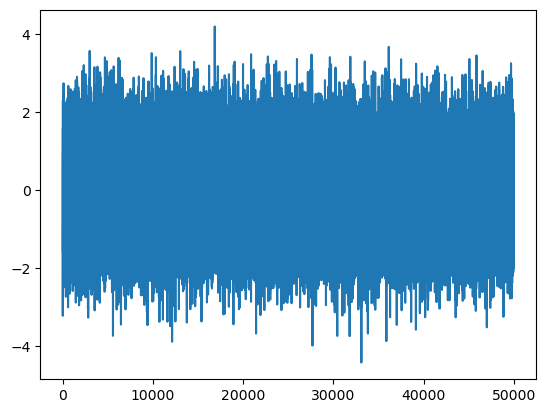

In [29]:
plt.plot(random_points)
plt.show()

The points indeed look pretty random. Since ANOVA test is designed for multiple data samples (or multiple groups), we will group the data into 50 samples of 1000 points each. 
Next, we will calculate the mean and standard deviation for each sample and plot them with error bars.

Instead of creating the new array with the size of (50, 1000) we can use the `np.reshape` function to reshape the original array into the desired shape.
It works in the following way:

```python
N = 1000
M = 50
initial_array = np.random.normal(0, 1, N*M)
reshaped_array = np.reshape(initial_array, (M, N))
```

In [30]:
num_samples = 50
num_points_per_sample = 1000
random_samples = np.reshape(random_points, (num_samples, num_points_per_sample))

print("Old shape: ", random_points.shape)
print("New shape: ", random_samples.shape)

Old shape:  (50000,)
New shape:  (50, 1000)


In [55]:
means = np.mean(random_samples, axis=1)
stds = np.std(random_samples, axis=1)

To plot the means values of each sample with the errorbars defined by their standard deviation, we can use the `plt.errorbar` function.

```python
plt.errorbar(x, y, yerr=std, fmt='o')
```

Where `x` is the x-axis values, `y` is the y-axis values, `yerr` is the error values, and `fmt` defines the symbol for plotting the points (in this case, 'o' for circles).

Since in our case we don't have specific x-axis values, we can use the indices of the samples as x-axis values.

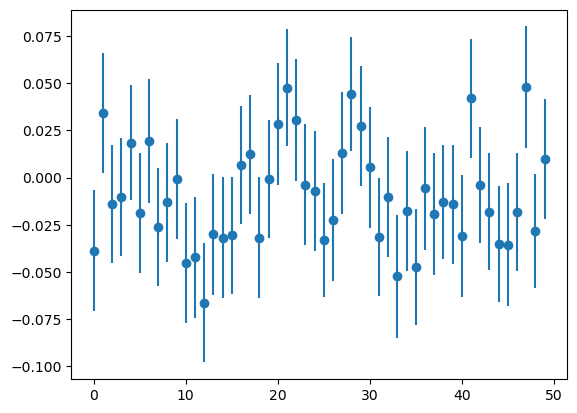

In [56]:
plt.errorbar(np.arange(num_samples), means, yerr=stds/np.sqrt(num_points_per_sample), fmt='o')
plt.show()

As we expected for the standard normal distribution, the mean values are around 0, and the error bars are about 1.0.

### Running ANOVA test

Let's now perform the ANOVA test on the random data. The ANOVA test is used to determine whether there are any statistically significant differences between the means of three or more independent (unrelated) groups.

Given that we have 50 samples ($n$) of 1000 points each ($m$), we need to calculate the following values to perform the ANOVA test:


- The error sum of squares (SSE): $$SSE = \sum_{i=1}^{n} \sum_{j=1}^{m} (X_{ij} - \bar{X}_{i})^2 $$ 
We can calculate the SSE by first calculating the difference between the data in each sample and the mean of that sample, squaring the difference, and then summing all the squared differences.

- The sum of squares between the samples (SSB):  $$ SSB = \sum_{i=1}^{n} m (\bar{X}_{i} - \bar{X})^2 = m \sum_{i=1}^{n}  (\bar{X}_{i} - \bar{X})^2 $$
We can calculate the SSB by first calculating the difference between the mean of each sample and the overall mean, squaring the difference, multiplying by the number of data points in each sample, and then summing all the squared differences.

- The total sum of squares (SST): $$ SST = SSE + SSB $$

- The degrees of freedom between samples: $$ df_{b} = n - 1 $$

- The degrees of freedom within samples: $$ df_{e} = n(m-1) $$

In [40]:
# Implement these functions:

def calculate_sse(samples, means, num_samples):
    sse = 0 
    for i in range(num_samples):
        sse += np.sum((samples[i] - means[i])**2)
    return sse

def calculate_ssb(means, num_samples, num_points_per_sample):
    ssb = 0
    total_mean = np.mean(means)
    for i in range(num_samples):
        ssb += num_points_per_sample * (means[i] - total_mean)**2 
    return ssb

In [41]:
SSE = calculate_sse(random_samples, means, num_samples)
SSB = calculate_ssb(means, num_samples, num_points_per_sample)

dfb = num_samples - 1
dfe = num_samples * (num_points_per_sample - 1)

In [42]:
print("Error Sum of Squares (SSE): ", SSE)
print("Sum of Squares between samples (SSB): ", SSB)
print("Degrees of freedom between samples (dfb): ", dfb)
print("Degrees of freedom within samples (dfe): ", dfe)

Error Sum of Squares (SSE):  49939.338441056374
Sum of Squares between samples (SSB):  37.82251274054989
Degrees of freedom between samples (dfb):  49
Degrees of freedom within samples (dfe):  49950


We can also use the vectorized operations in NumPy to calculate these values efficiently. The main idea is to directly operate on 2D array (`samples`) to calculate the mean values and then use broadcasting to calculate the differences and sums.

The issue is that `means` is a 1D array, and we cannot directly subtract it from the 2D array `samples`. We first need to reshape the `means` array to have the same shape as the `samples` array.

```python
means = means.reshape(len(samples), 1) # Reshape to (n, 1)
```

Now we can subtract the `means` array from the `samples` array. It will automatically subtract the corresponding mean value from each row of the `samples` array.

```python
diff = samples - means
```

This will return the array of the same shape as the `samples` array, where each element is the difference between the data point and the mean of the corresponding sample.

In [36]:
def calculate_sse_vectorized(samples, means):
    return np.sum((samples - means.reshape(len(samples), 1)) ** 2)

def calculate_ssb_vectorized(means, num_points_per_sample):
    total_mean = np.mean(means)
    return num_points_per_sample * np.sum((means - total_mean) ** 2)

In [37]:
SSE_vec = calculate_sse_vectorized(random_samples, means)
SSB_vec = calculate_ssb_vectorized(means, num_points_per_sample)

print("SSE and SSE_vec are equal: ", np.isclose(SSE, SSE_vec))
print("SSB and SSB_vec are equal: ", np.isclose(SSB, SSB_vec))

SSE and SSE_vec are equal:  True
SSB and SSB_vec are equal:  True


To finish the ANOVA test, we need to calculate the mean square between samples (MSB) and the mean square within samples (MSE). The F-statistic is then calculated as the ratio of MSB to MSW.

$$ MSB = \frac{SSB}{df_{b}} $$
$$ MSE = \frac{SSE}{df_{e}} $$
$$ F = \frac{MSB}{MSE} $$

Finally, we compare the F-statistic to the critical value from the F-distribution with degrees of freedom $df_{b}$ and $df_{e}$ at a desired significance level (in our case 0.05).

In [43]:
MSB = SSB / dfb
MSE = SSE / dfe
F = MSB / MSE

print("Mean Square between samples (MSB): ", MSB)
print("Mean Square within samples (MSE): ", MSE)
print("F-value: ", F)

print("Critical F-value: ", 1.354) # for alpha = 0.05, dfb = 49, dfe = 49950

Mean Square between samples (MSB):  0.7718880151132631
Mean Square within samples (MSE):  0.999786555376504
F-value:  0.7720528056336806
Critical F-value:  1.354


Since our F-statistic is less than the crititical value, we cannot reject the null hypothesis (i.e. we cannot say that the data in the samples differs significantly).

Let's summarize the results in the [ANOVA table](https://d138zd1ktt9iqe.cloudfront.net/media/seo_landing_files/anova-table-1642579664.png).

In [44]:
def print_anova_table(SSE, SSB, dfb, dfe):
    MSB = SSB / dfb
    MSE = SSE / dfe
    F = MSB / MSE
    total_SS = SSB + SSE
    total_df = dfb + dfe

    print(f"{'Source':<20} | {'Sum of Squares (SS)':<20} | {'Degrees of Freedom (df)':<20} | {'Mean Square (MS)':<20} | {'F-value':<10}")
    print("-" * 105)
    print(f"{'Between samples':<20} | {SSB:<20.2f} | {dfb:<20}    | {MSB:<20.2f} | {F:<10.2f}")
    print(f"{'Within samples':<20} | {SSE:<20.2f} | {dfe:<20}    | {MSE:<20.2f}")
    print(f"{'Total':<20} | {total_SS:<20.2f} | {total_df:<20}")


print_anova_table(SSE, SSB, dfb, dfe)

Source               | Sum of Squares (SS)  | Degrees of Freedom (df) | Mean Square (MS)     | F-value   
---------------------------------------------------------------------------------------------------------
Between samples      | 37.82                | 49                      | 0.77                 | 0.77      
Within samples       | 49939.34             | 49950                   | 1.00                
Total                | 49977.16             | 49999               


## 2. Practicing ANOVA on Lab Data

Now let's repeat the same analysis on the data from our lab. This data will contain some slow drifts, which might introduce some differences between the samples.

In [45]:
lab_data = np.loadtxt('/Users/arslanmazitov/courses/psms/ex10/BFieldVSTime.csv')

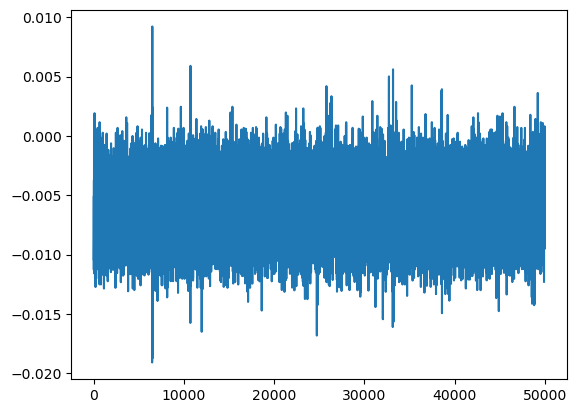

In [67]:
plt.plot(lab_data)
plt.show()

In [60]:
sampled_lab_data = np.reshape(lab_data, (num_samples, num_points_per_sample))

In [62]:
means = np.mean(sampled_lab_data, axis=1)
stds = np.std(sampled_lab_data, axis=1)

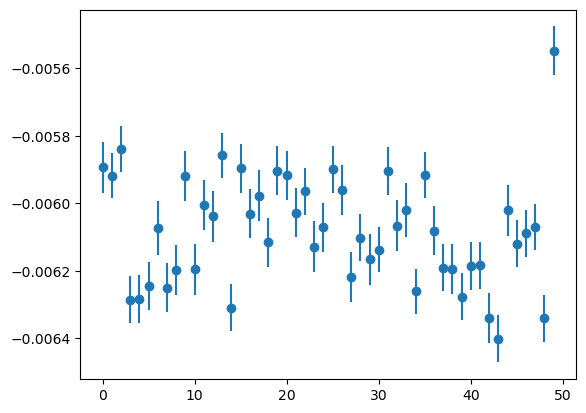

In [63]:
plt.errorbar(np.arange(num_samples), means, yerr=stds/np.sqrt(num_points_per_sample), fmt='o')
plt.show()

In [64]:
SSE = calculate_sse(sampled_lab_data, means, num_samples)
SSB = calculate_ssb(means, num_samples, num_points_per_sample)

dfb = num_samples - 1
dfe = num_samples * (num_points_per_sample - 1)

In [65]:
print("Error Sum of Squares (SSE): ", SSE)
print("Sum of Squares between samples (SSB): ", SSB)
print("Degrees of freedom between samples (dfb): ", dfb)
print("Degrees of freedom within samples (dfe): ", dfe)

Error Sum of Squares (SSE):  0.26074343891734947
Sum of Squares between samples (SSB):  0.0013302198899046197
Degrees of freedom between samples (dfb):  49
Degrees of freedom within samples (dfe):  49950


In [66]:
MSB = SSB / dfb
MSE = SSE / dfe
F = MSB / MSE

print("Mean Square between samples (MSB): ", MSB)
print("Mean Square within samples (MSE): ", MSE)
print("F-value: ", F)

print("Critical F-value: ", 1.354) # for alpha = 0.05, dfb = 49, dfe = 49950

Mean Square between samples (MSB):  2.7147344691931013e-05
Mean Square within samples (MSE):  5.220088867214203e-06
F-value:  5.200552209452843
Critical F-value:  1.354
